<a href="https://colab.research.google.com/github/brn1214/CNN-Low-Light/blob/main/lowlight_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch


# Detectar si CUDA está disponible, de lo contrario usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Usando el dispositivo: {device}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import glob
import random
import math
import torch.optim
import os
import argparse

import matplotlib.pyplot as plt

 # Convertir imagenes

## RGB -> YIQ

In [ ]:
import numpy as np

def rgb_to_yiq(rgb):
    # Asume que rgb es un tensor de PyTorch con dimensiones [batch_size, 3, height, width]
    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    i = 0.596 * r - 0.274 * g - 0.322 * b
    q = 0.211 * r - 0.523 * g + 0.312 * b
    return torch.stack([y, i, q], dim=1)


def normalize(image, range=(0, 1)):

    # Calcula los valores mínimos y máximos globales en todo el tensor
    min_val = torch.min(image)
    max_val = torch.max(image)

    # Normaliza el tensor
    normalized = (image - min_val) / (max_val - min_val) * (range[1] - range[0]) + range[0]

    return normalized


## YIQ -> RGB

In [ ]:
def yiq_to_rgb(yiq):
    y = yiq[:, 0:1, :, :]
    i = yiq[:, 1:2, :, :]
    q = yiq[:, 2:3, :, :]

    r = y + 0.956*i + 0.621*q
    g = y - 0.272*i - 0.647*q
    b = y - 1.106*i + 1.703*q

    rgb = torch.cat((r, g, b), dim=1)
    return rgb


## Curva S

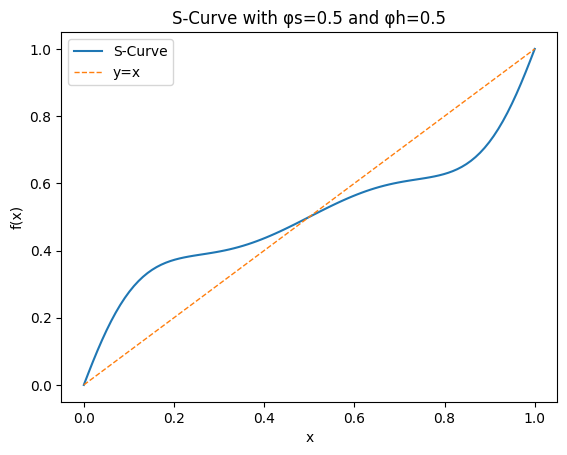

In [3]:
def apply_s_curve(luminance, phi_s, phi_h, k1=5, k2=14, k3=1.6):

    x = luminance
    x_1 = 1 - x

    f_x = k1 * x * torch.exp(-k2 * x**k3)
    f_x_1 = k1 * (x_1) * torch.exp(-k2 * (x_1)**k3)

    adjusted_luminance = x + phi_s * f_x - phi_h * f_x_1 #f_x.flip(dims=[-1])

    return adjusted_luminance

# Define la función ajustada según los parámetros proporcionados
def funcion_ejemplo(x, phi_s=0.5, phi_h=0.5, k1=5, k2=14, k3=1.6):
    x_1 = 1 - x
    f_x = k1 * x * np.exp(-k2 * x**k3)
    f_x_1 = k1 * x_1 * np.exp(-k2 * x_1**k3)
    adjusted_luminance = x + phi_s * f_x - phi_h * f_x_1
    return adjusted_luminance

def funcion_fx(x, phi_s=0.5, phi_h=0.5, k1=5, k2=14, k3=1.6):

    f_x = k1 * x * np.exp(-k2 * x**k3)

    return f_x

# Genera un conjunto de valores de x entre 0 y 1.
x_valores = np.linspace(0, 1, 100)  # 100 puntos entre 0 y 1.

# Calcula los valores de y usando la función definida.
y_valores = funcion_ejemplo(x_valores)

# Calcula los valores de y usando la función definida.
fx_valores = funcion_fx(x_valores)

# Crea el gráfico para la función ajustada
plt.plot(x_valores, y_valores, label='S-Curve')

# Grafica y=x con una línea rayada y delgada
plt.plot(x_valores, x_valores, '--', label='y=x', linewidth=1)

# Grafica dfx con una línea rayada y delgada
#plt.plot(x_valores, fx_valores, '--', label='dF(x)', linewidth=1)

# Añade títulos y etiquetas.
plt.title('S-Curve with φs=0.5 and φh=0.5')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

# Muestra el gráfico.
plt.show()

## Ajusta canales YIQ

In [ ]:
import torch

def adjust_iq_channels(yiq, luminance_adjusted):
    """
    Ajusta los canales I y Q en el espacio de color YIQ basándose en la relación de cambio en la luminancia.

    :param yiq: Tensor de PyTorch con la imagen original en espacio de color YIQ.
               Formato esperado: [batch_size, 3, height, width]
    :param luminance_adjusted: Tensor de PyTorch con el canal de luminancia (Y) ajustado.
               Formato esperado: [batch_size, 1, height, width]
    :return: Imagen en espacio de color YIQ con canales I y Q ajustados.
    """
    # No es necesario usar squeeze que puede alterar la estructura esperada
    y_original = yiq[:, 0:1, :, :]  # Extraer Y original
    i = yiq[:, 1:2, :, :]  # Extraer I
    q = yiq[:, 2:3, :, :]  # Extraer Q

    a = luminance_adjusted/(y_original+0.0001)

    # Ajustar canales I y Q
    i_adjusted = i * a
    q_adjusted = q * a

    # Retornar el tensor con los canales ajustados
    return torch.cat([luminance_adjusted, i_adjusted, q_adjusted], dim=1)



# Dataloader

Carga los datos

In [ ]:


random.seed(1143)

def populate_train_list(lowlight_images_path):

    image_list_lowlight = glob.glob(lowlight_images_path + "*.jpg")

    train_list = image_list_lowlight

    random.shuffle(train_list)

    return train_list


class lowlight_loader(data.Dataset):

    def __init__(self, lowlight_images_path):

        self.train_list = populate_train_list(lowlight_images_path)
        self.size = 256

        self.data_list = self.train_list
        print("Total training examples:", len(self.train_list))

    def __getitem__(self, index):

        data_lowlight_path = self.data_list[index]

        data_lowlight = Image.open(data_lowlight_path)

        data_lowlight = data_lowlight.resize((self.size,self.size), Image.Resampling.LANCZOS)

        data_lowlight = (np.asarray(data_lowlight)/255.0)
        data_lowlight = torch.from_numpy(data_lowlight).float()

        return data_lowlight.permute(2,0,1)

    def __len__(self):
        return len(self.data_list)

# Pérdidas *Losses*

## L_color

In [ ]:
class L_color(nn.Module):

    def __init__(self):
        super(L_color, self).__init__()

    def forward(self, x ):

        b,c,h,w = x.shape

        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)

        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)
        #k = Drg + Drb + Dgb

        #k[torch.isnan(k)] = 0  # Reemplaza NaNs con 0
        #k[torch.isinf(k)] = 0  # Reemplaza Infs con 0




        return k

x = torch.rand(8, 3, 512, 512)   # Values between -1 and 1
l_col = L_color()

# Apply the operation and print the result
result = l_col(x)
print(f"Result: {result*5}")



## L_Spa

In [ ]:
class L_spa(nn.Module):

    def __init__(self):
        super(L_spa, self).__init__()
        # print(1)kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        kernel_left = torch.FloatTensor( [[0,0,0],[-1,1,0],[0,0,0]]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor( [[0,0,0],[0,1,-1],[0,0,0]]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor( [[0,-1,0],[0,1, 0 ],[0,0,0]]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor( [[0,0,0],[0,1, 0],[0,-1,0]]).to(device).unsqueeze(0).unsqueeze(0)
        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        self.pool = nn.AvgPool2d(4)

    def forward(self, org , enhance ):

        b,c,h,w = org.shape

        org_mean = torch.mean(org,1,keepdim=True)
        enhance_mean = torch.mean(enhance,1,keepdim=True)

        org_pool =  self.pool(org_mean)
        enhance_pool = self.pool(enhance_mean)

        D_org_left = F.conv2d(org_pool , self.weight_left, padding=1)
        D_org_right = F.conv2d(org_pool , self.weight_right, padding=1)
        D_org_up = F.conv2d(org_pool , self.weight_up, padding=1)
        D_org_down = F.conv2d(org_pool , self.weight_down, padding=1)

        D_enhance_letf = F.conv2d(enhance_pool , self.weight_left, padding=1)
        D_enhance_right = F.conv2d(enhance_pool , self.weight_right, padding=1)
        D_enhance_up = F.conv2d(enhance_pool , self.weight_up, padding=1)
        D_enhance_down = F.conv2d(enhance_pool , self.weight_down, padding=1)

        D1_left = org_pool - D_org_left
        D1_right = org_pool - D_org_right
        D1_up = org_pool - D_org_up
        D1_down = org_pool - D_org_down

        D2_left = enhance_pool - D_enhance_letf
        D2_right = enhance_pool - D_enhance_right
        D2_up = enhance_pool - D_enhance_up
        D2_down = enhance_pool - D_enhance_down

        D_left = torch.pow(torch.abs(D1_left) - torch.abs(D2_left),2)
        D_right = torch.pow(torch.abs(D1_right) - torch.abs(D2_right),2)
        D_up = torch.pow(torch.abs(D1_up) - torch.abs(D2_up),2)
        D_down = torch.pow(torch.abs(D1_down) - torch.abs(D2_down),2)

        E = (D_left + D_right + D_up +D_down)

        #E[torch.isnan(E)] = 0  # Reemplaza NaNs con 0
        #E[torch.isinf(E)] = 0  # Reemplaza Infs con 0

        E_s = torch.mean(E)

        return E_s

x = torch.rand(8, 3, 256, 256).to(device)   # Values between -1 and 1
x_hat = torch.rand(8, 3, 256, 256).to(device)

# Initialize the L_exp class
l_spa = L_spa()


# Apply the operation and print the result
result = l_spa(x, x_hat)
print(f"Result: {result}")

## L_exp

In [ ]:
class L_exp(nn.Module):

    def __init__(self,patch_size=16,mean_val=0.5):
        super(L_exp, self).__init__()
        # print(1)
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val

    def forward(self, x, x_hat ):

        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        x_hat = torch.mean(x_hat,1,keepdim=True)

        mean = self.pool(x)
        mean_hat = self.pool(x_hat)

        subs = mean_hat - mean

        d = torch.mean(torch.pow(torch.sign(mean_hat - torch.FloatTensor([self.mean_val]).to(device))*subs ,2))
        #print(mean)
        #print(subs)
        #print(torch.sign(mean_hat - torch.FloatTensor([self.mean_val]))*subs )
        return d

## L_TV

In [ ]:
class L_TV(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(L_TV,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)

        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()

        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size





x = torch.rand(8, 3, 256, 256).to(device)   # Values between -1 and 1
x_hat = torch.rand(8, 3, 256, 256).to(device)

# Initialize the L_exp class
l_spa = L_TV()


# Apply the operation and print the result
result = l_spa(x)
print(f"Result: {result}")



# Model

Aqui se entrena el modelo

## Definicion de los modulos

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1,bias=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = Conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = Conv(in_channels, out_channels)
        self.up = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)


    def forward(self, x1, x2):
        x_1 = self.conv(x1)
        x_1a = self.up(x_1)
        x = torch.cat([x_1a, x2], 1)

        return x



## Modelo *UDNeT*

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv_in = Conv(in_channels, 64)

        self.down_convolution_1 = DownSample(64, 128)
        self.down_convolution_2 = DownSample(128, 256)

        self.bottle_neck = Conv(256, 256)
        self.bottle_neck1 = Conv(256, 256)

        self.up_convolution_1 = UpSample(256+256, 128)
        self.up_convolution_2 = UpSample(128+128, 64)

        #self.conv_out = Conv(64, 2)

        self.out = nn.Sequential(
            nn.Conv2d(64+64, out_channels=num_classes, kernel_size=1),
            nn.Sigmoid()
        )



    def forward(self, x):

        x1 = self.conv_in(x)
        #print("x1")
        #nando(x1)

        c1, d1 = self.down_convolution_1(x1)
        #print("p1 ", {p1.shape})
        c2, d2 = self.down_convolution_2(d1)

        #print("p2 ", {p2.shape})
        b = self.bottle_neck(d2)
        #print("b ", {b.shape})
        b2 = self.bottle_neck1(b)

        b_cat = torch.cat([b, d2], 1)


        #print("b2 ", {b2.shape})

        up_1 = self.up_convolution_1(b_cat, d1)
        #print("up1 ", {up_1.shape})
        up_2 = self.up_convolution_2(up_1, x1)
        #print("up2 ", {up_2.shape})
        logits = self.out(up_2)

        #print("logits")
        #nando(logits)

        # Dividir logits en phi_s y phi_h
        phi_s = logits[:, 0:1, :, :]  # Primer canal para phi_s
        phi_h = logits[:, 1:2, :, :]  # Segundo canal para phi_h

        #img = apply_s_curve(x,phi_s, phi_h )


        return phi_s, phi_h
"""
# Si inicializas la red así:
unet = UNet(in_channels=1, num_classes=2)  # Suponiendo que el canal de luminancia es la única entrada
x = torch.rand(8, 1, 280, 256)   # Values between -1 and 1



# Apply the operation and print the result
s, h = unet(batch_tensor_img)

print(s.shape)
print(h.shape)

t = apply_s_curve(batch_tensor_img, s, h)
print(t.shape)

verimg(batch_tensor_img[1])
verimg(t[1])
"""

In [ ]:
lambda_e=10
lambda_t=200
lambda_s=1
lambda_c=5

ruta = '/content/drive/MyDrive/tesis/'

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0.2)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0)


In [ ]:
def train(config):

    UNet_net = UNet(in_channels=1, num_classes=2).to(device)

    UNet_net.apply(initialize_weights)

    #UNet_net.apply(weights_init)





    if config.load_pretrain == True:
        #UNet_net.load_state_dict(torch.load(config.pretrain_dir))
        model_state = torch.load(config.pretrain_dir, map_location=torch.device('cpu'))
        UNet_net.load_state_dict(model_state)
        print("Cargó el peso correctamente en CPU.")
        print("carga el peso")

    train_dataset = lowlight_loader(config.lowlight_images_path)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)


    l_color = L_color()
    l_spa = L_spa()

    l_exp = L_exp(16,0.5)
    l_TV = L_TV()
    loss = 0

    optimizer = torch.optim.Adam(UNet_net.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    UNet_net.train()



    for epoch in range(config.num_epochs):
        print(f"EPOCA +++++++ {epoch} ++++++++++")

        for iteration, img_lowlight in enumerate(train_loader):





            img_lowlight = img_lowlight.to(device)

            image_yiq = rgb_to_yiq(img_lowlight)


            image_yiq1 = normalize(image_yiq, range=(0, 1))

            image_y = image_yiq1[:, 0:1, :, :]   # Extraer el canal Y


            #verimg(img_lowlight[0])        image_rgb = yiq_to_rgb(image_yiq)

            phi_s, phi_h  = UNet_net(image_y)


            image_y_adjusted = apply_s_curve(image_y,phi_s, phi_h )


            adjusted_yiq = adjust_iq_channels(image_yiq, image_y_adjusted)


            adjusted_rgb = yiq_to_rgb(adjusted_yiq)





            Loss_TV = torch.mean(l_TV(image_y_adjusted))
            loss_spa = torch.mean(l_spa(img_lowlight, adjusted_rgb))
            loss_col = torch.mean(l_color(adjusted_rgb))
            loss_exp = torch.mean(l_exp(image_y, image_y_adjusted))


            # best_loss
            loss =  Loss_TV*lambda_t + loss_spa*lambda_s + loss_col*lambda_c + loss_exp*lambda_e

            if ((iteration+1) % 5) == 0:
                print(f"iteracion {iteration}: --> {loss.item()}")




            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(UNet_net.parameters(),config.grad_clip_norm)
            optimizer.step()
            '''
            for name, param in UNet_net.named_parameters():
                if param.requires_grad:
                    print(f"{name} - mean: {param.data.mean()}, max: {param.data.max()}, min: {param.data.min()}")

            '''

            if ((iteration+1) % config.display_iter) == 0:
                print("Loss at iteration", iteration+1, ":", loss.item())
                verimg2(img_lowlight[2],adjusted_rgb[2])

            if ((iteration+1) % config.snapshot_iter) == 0:

                torch.save(UNet_net.state_dict(), config.snapshots_folder + "Epoch" + str(epoch) + '.pth')


if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # Input Parameters
    parser.add_argument('--lowlight_images_path', type=str, default=ruta+"data/train_data/")
    parser.add_argument('--lr', type=float, default=0.0001)
    parser.add_argument('--weight_decay', type=float, default=0.0001)
    parser.add_argument('--grad_clip_norm', type=float, default=0.1)
    parser.add_argument('--num_epochs', type=int, default=200)
    parser.add_argument('--train_batch_size', type=int, default=8)
    parser.add_argument('--val_batch_size', type=int, default=4)
    parser.add_argument('--num_workers', type=int, default=0)
    parser.add_argument('--display_iter', type=int, default=50)
    parser.add_argument('--snapshot_iter', type=int, default=10)
    parser.add_argument('--snapshots_folder', type=str, default=ruta+"snapshots/")
    parser.add_argument('--load_pretrain', type=bool, default= True)
    parser.add_argument('--pretrain_dir', type=str, default= ruta+"snapshots/Epoch9.pth")

    config, unknown = parser.parse_known_args()


    if not os.path.exists(config.snapshots_folder):
        os.mkdir(config.snapshots_folder)

    train(config)







In [ ]:
def verimg(img):
    # Asegúrate de que el tensor esté en CPU y en el formato adecuado
    img = img.detach().cpu().numpy()

    # Transponer el tensor de [3, 256, 256] a [256, 256, 3] para visualización
    # Cambiamos el orden de los ejes para que sea (altura, anchura, canales)
    img = img.transpose((1, 2, 0))

    # Configurar el tamaño de la figura para una buena visualización
    plt.figure(figsize=(6, 6))  # Tamaño suficiente para una sola imagen

    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')  # Ocultar los ejes

    plt.show()


In [ ]:
def verimg2(img1, img2):
    # Configurar el tamaño de la figura para una buena visualización
    plt.figure(figsize=(12, 6))  # Aumentar el ancho para acomodar dos imágenes

    # Preparar la primera imagen
    img1 = img1.detach().cpu().numpy()  # Asegúrate de que el tensor esté en CPU y en el formato adecuado
    img1 = img1.transpose((1, 2, 0))  # Cambiamos el orden de los ejes para que sea (altura, anchura, canales)

    # Mostrar la primera imagen
    ax1 = plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, índice de imagen 1
    ax1.imshow(img1)
    ax1.axis('off')  # Ocultar los ejes

    # Preparar la segunda imagen
    img2 = img2.detach().cpu().numpy()  # Repetir el proceso para la segunda imagen
    img2 = img2.transpose((1, 2, 0))

    # Mostrar la segunda imagen
    ax2 = plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, índice de imagen 2
    ax2.imshow(img2)
    ax2.axis('off')  # Ocultar los ejes

    plt.show()

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

# Define las transformaciones necesarias para convertir la imagen
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convierte a escala de grises si es necesario
    transforms.Resize((280, 256)),  # Cambia el tamaño de la imagen a las dimensiones deseadas
    transforms.ToTensor(),  # Convierte la imagen a un tensor y escala a [0, 1]
])

# Cargar la imagen usando PIL
img = Image.open('img4.jpg')

# Aplicar las transformaciones
tensor_img = transform(img)

verimg(tensor_img)

# Verificar la forma del tensor y los valores
print(tensor_img.shape)  # Debería mostrar torch.Size([1, 280, 256])
print("Valores mínimos y máximos:", tensor_img.min().item(), tensor_img.max().item())

# Si necesitas un batch de tamaño 8 con la misma imagen
batch_tensor_img = tensor_img.unsqueeze(0).repeat(8, 1, 1, 1)  # Crea un batch repitiendo la imagen
print(batch_tensor_img.shape)  # Debería ser torch.Size([8, 1, 280, 256])


In [ ]:
def valores(tensor):
    for i in range(tensor.size(0)):  # tensor.size(0) es el tamaño del batch, que es 8
        print(f"Imagen {i+1}:")
        # Iterar sobre cada canal
        for j in range(tensor.size(1)):  # tensor.size(1) es el número de canales, que es 3
            channel = tensor[i, j, :, :]  # Extraer el canal j de la imagen i
            max_val = torch.max(channel).item()  # Valor máximo en el canal
            min_val = torch.min(channel).item()  # Valor mínimo en el canal
            print(f"  Canal {j}: Máximo = {max_val}, Mínimo = {min_val}")